In [1]:
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Correct dataset paths based on your Kaggle dataset structure
brain_tumor_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes"
no_tumor_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no"


In [3]:
# Check if dataset directories exist
if not os.path.exists(brain_tumor_path) or not os.path.exists(no_tumor_path):
    raise ValueError("Dataset paths are incorrect! Check the correct dataset folder name.")

# List files to verify data availability
print("Tumor images:", os.listdir(brain_tumor_path)[:5])  # Show first 5 tumor images
print("Non-Tumor images:", os.listdir(no_tumor_path)[:5])  # Show first 5 non-tumor images

Tumor images: ['Y115.JPG', 'Y192.JPG', 'Y162.jpg', 'Y9.jpg', 'Y108.jpg']
Non-Tumor images: ['34 no.jpg', 'N20.JPG', 'N1.JPG', '49 no.jpg', 'N15.jpg']


In [4]:
data = []

labels = []

IMG_SIZE = 128 # Define image size for clarity
 
# Load Tumor images

print(f"\nLoading images from: {brain_tumor_path}")

count_tumor = 0

for r, d, f in os.walk(brain_tumor_path):

    for file in f:

        if file.lower().endswith(('.jpg', '.jpeg', '.png')): # Handle different extensions

            try:

                img_path = os.path.join(r, file)

                img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE)) # Ensure RGB, resize

                img_array = np.array(img)

                if img_array.shape == (IMG_SIZE, IMG_SIZE, 3):  # Ensure valid image

                    data.append(img_array)

                    labels.append(0)  # Label 0 for Tumor

                    count_tumor +=1

                else:

                    print(f"Skipping tumor image {file} due to unexpected shape: {img_array.shape}")

            except Exception as e:

                print(f"Error loading tumor image {file}: {e}")

print(f"Loaded {count_tumor} tumor images.")
 
# Load Non-Tumor images

print(f"\nLoading images from: {no_tumor_path}")

count_no_tumor = 0

for r, d, f in os.walk(no_tumor_path):

    for file in f:

        if file.lower().endswith(('.jpg', '.jpeg', '.png')):

            try:

                img_path = os.path.join(r, file)

                img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE)) # Ensure RGB, resize

                img_array = np.array(img)

                if img_array.shape == (IMG_SIZE, IMG_SIZE, 3):  # Ensure valid image

                    data.append(img_array)

                    labels.append(1)  # Label 1 for No Tumor

                    count_no_tumor += 1

                else:

                    print(f"Skipping non-tumor image {file} due to unexpected shape: {img_array.shape}")

            except Exception as e:

                print(f"Error loading non-tumor image {file}: {e}")

print(f"Loaded {count_no_tumor} non-tumor images.")
 


Loading images from: /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes
Loaded 155 tumor images.

Loading images from: /kaggle/input/brain-mri-images-for-brain-tumor-detection/no
Loaded 98 non-tumor images.


In [5]:
print(f"Total images loaded: {len(data)}")
print(f"Total labels loaded: {len(labels)}")

if len(data) == 0:
    raise ValueError("No images were loaded. Verify dataset paths and image formats.")

Total images loaded: 253
Total labels loaded: 253


In [6]:
data = np.array(data, dtype=np.float32) / 255.0  # Normalize pixel values
labels = np.array(labels)

In [7]:
# Split data into training, validation, and test sets

# First, split into (training + validation) and test sets

# Aim for roughly 60% train, 20% validation, 20% test.

# Or, if keeping test_size=0.2 for final test, then from the remaining 80%, take 0.25 for validation (0.25 * 0.8 = 0.2)
 
# Step 1: Split into (train + validation) and test

# Let's use 20% for the test set.

x_temp, x_test, y_temp, y_test = train_test_split(

    data, labels,

    test_size=0.20,       # 20% of data for the final test set

    shuffle=True,

    random_state=42,      # For reproducibility

    stratify=labels       # Important for small/imbalanced datasets

)
 
# Step 2: Split (train + validation) into actual training and validation sets

# From the remaining 80% (x_temp), take 25% for validation, which is 0.25 * 0.80 = 20% of the original data.

x_train, x_val, y_train, y_val = train_test_split(

    x_temp, y_temp,

    test_size=0.25,       # 25% of x_temp (which is 80% of original) for validation

    shuffle=True,

    random_state=42,      # For reproducibility

    stratify=y_temp       # Stratify on the labels of this subset

)
 
# Confirm dataset shapes and distribution

print(f"Total samples: {len(data)}")

print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")

print(f"Validation data shape: {x_val.shape}, Validation labels shape: {y_val.shape}")

print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")
 
print(f"\nNumber of training samples: {len(x_train)}")

print(f"Number of validation samples: {len(x_val)}")

print(f"Number of test samples: {len(x_test)}")
 
print(f"\nTraining label distribution: {np.unique(y_train, return_counts=True)}")

print(f"Validation label distribution: {np.unique(y_val, return_counts=True)}")

print(f"Test label distribution: {np.unique(y_test, return_counts=True)}")
 

Total samples: 253
Training data shape: (151, 128, 128, 3), Training labels shape: (151,)
Validation data shape: (51, 128, 128, 3), Validation labels shape: (51,)
Test data shape: (51, 128, 128, 3), Test labels shape: (51,)

Number of training samples: 151
Number of validation samples: 51
Number of test samples: 51

Training label distribution: (array([0, 1]), array([93, 58]))
Validation label distribution: (array([0, 1]), array([31, 20]))
Test label distribution: (array([0, 1]), array([31, 20]))


In [8]:
# Define the model structure
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary classification (Tumor vs No Tumor)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 424ms/step - accuracy: 0.6043 - loss: 9.1935 - val_accuracy: 0.6667 - val_loss: 0.7572
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.6668 - loss: 4.0971 - val_accuracy: 0.6275 - val_loss: 1.1670
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.8691 - loss: 1.2770 - val_accuracy: 0.6078 - val_loss: 2.5202
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - accuracy: 0.7959 - loss: 2.0654 - val_accuracy: 0.5686 - val_loss: 3.4373
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 416ms/step - accuracy: 0.7889 - loss: 2.2278 - val_accuracy: 0.6078 - val_loss: 3.6748
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8870 - loss: 0.9819 - val_accuracy: 0.5882 - val_loss: 3.0586
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.8670 - loss: 0.9027 - val_accuracy: 0.5882 - val_loss: 2.9555
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9548 - loss: 0.5273 - val_accu

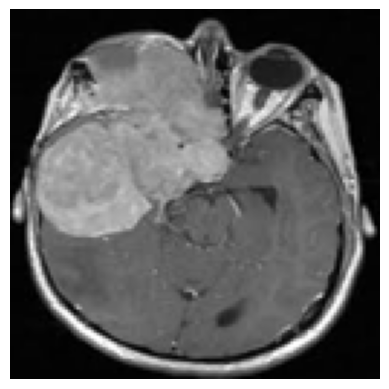

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Prediction: Tumor Detected


In [9]:
# Load a test image
img_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y106.jpg"  # Replace with a valid image path
img = Image.open(img_path).resize((128, 128))  # Resize to match model input size
img_array = np.array(img) / 255.0  # Normalize

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Reshape image for prediction (1, 128, 128, 3)
img_array = img_array.reshape(1, 128, 128, 3)

# Make prediction
prediction = model.predict(img_array)
predicted_class = int(prediction[0][0] > 0.5)  # 0 = Tumor, 1 = No Tumor

# Display result
if predicted_class == 0:
    print("Prediction: Tumor Detected")
else:
    print("Prediction: No Tumor Detected")


--- Evaluating Model Performance ---
Training Accuracy: 100.00%
Training Loss: 0.0000
Validation Accuracy: 82.35%
Validation Loss: 2.3259
Test Accuracy: 74.51%
Test Loss: 4.1866


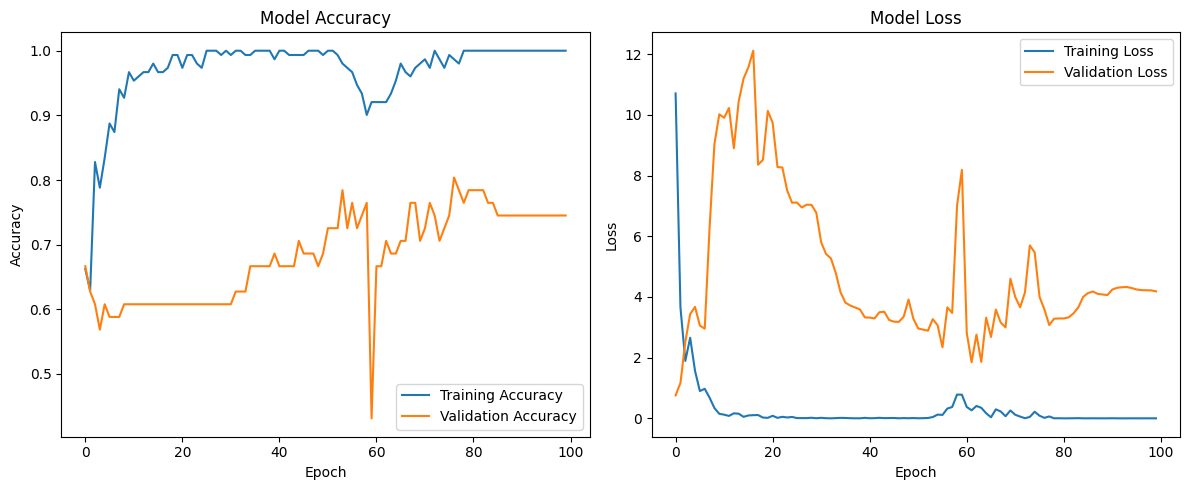

In [10]:
print("\n--- Evaluating Model Performance ---")
 
# Evaluate on training data

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)

print(f"Training Accuracy: {train_acc * 100:.2f}%")

print(f"Training Loss: {train_loss:.4f}")
 
# Evaluate on validation data

val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0) # MODIFIED: Evaluate on x_val

print(f"Validation Accuracy: {val_acc * 100:.2f}%")

print(f"Validation Loss: {val_loss:.4f}")
 
# Evaluate on TEST data (the truly unseen set)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0) # ADDED: Evaluate on x_test

print(f"Test Accuracy: {test_acc * 100:.2f}%")

print(f"Test Loss: {test_loss:.4f}")
 
 
# Plot training & validation accuracy and loss values from history

if history:

    plt.figure(figsize=(12, 5))
 
    # Plot accuracy

    plt.subplot(1, 2, 1)

    plt.plot(history.history['accuracy'], label='Training Accuracy')

    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    plt.title('Model Accuracy')

    plt.ylabel('Accuracy')

    plt.xlabel('Epoch')

    plt.legend(loc='lower right')
 
    # Plot loss

    plt.subplot(1, 2, 2)

    plt.plot(history.history['loss'], label='Training Loss')

    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Model Loss')

    plt.ylabel('Loss')

    plt.xlabel('Epoch')

    plt.legend(loc='upper right')
 
    plt.tight_layout()

    plt.show()
 